# Regional magnetization

$M^z_{A/B} = \frac2N \sum_{l\in {A,B}}\langle \sigma^z_l (t)\rangle$

In [110]:
from qutip import *
from scipy import signal
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.special import jn_zeros
from itertools import combinations
from multiprocessing import Pool

##--- Energy per spin for interaction range order---------
def j_ij(Jvalue, i,j, beta):
    return Jvalue/(np.abs(i-j))**beta

##-- Drive-------------------------------------------------

def drive1(t, args):
    w = args['omega']
    T = 2 * np.pi/w

    sqr1 = signal.square(2 * np.pi/T * t)
    if sqr1 == -1:
        sqr1= 0
    return sqr1

def drive2(t, args):
    w = args['omega']
    T = 2 * np.pi/w

    sqr1 = -signal.square(2 * np.pi/T * t)
    if sqr1 == -1:
        sqr1= 0
    return sqr1

def drive3(t, args):    # square cos wave transverse
    w = args['omega']
    h0 = args['h0']
    h = args['h']
    T = 2 * np.pi/w

    sint = -np.sin(w*t)
    if sint<=0:
        sint = 0
    sqrsin = h0 + h * sint
    return sqrsin

def get_hamiltonian(N,N1, lambd_x, lambd_y, Jvalue, beta, g, ea, eb):
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)
    H10, H11, H12, H21, H22, H23, H24 =  empt, empt, empt, empt, empt, empt, empt
    
    ##-- Hamiltonian ------------------------------------------- 
    ##-- First half

    for i in range(N1):  
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H11 = H11 + Qobj(tensor(id,tensor(sx,id1)).full()) * g * (1-ea)

    for i in range(N1,N):  
        id = qeye(2**i)    
        dim12 = N-1-i
        id1 = qeye(2**dim12)
        H12 = H12 + Qobj(tensor(id,tensor(sx,id1)).full()) * g * (1-eb)   

    ##-- Second half

    comb = combinations(np.arange(N), 2)
    for nm in list(comb):
        i,j= np.array(nm)
        id = qeye(2**i)
        dim11 = j-i-1
        id1 = qeye(2**dim11)
        dim12 = N-1-j
        id2 = qeye(2**dim12)
        H21 = H21 + Qobj(tensor(id, tensor(sy, tensor(id1, tensor(sy,id2)))).full()) * j_ij(Jvalue, i,j, beta)
        
    for i in range(N):  
        id = qeye(2**i)    
        dim22 = N-1-i
        id1 = qeye(2**dim22)
        H22 = H22 + Qobj(tensor(id,tensor(sz,id1)).full()) 

    for i in range(N):  
        id = qeye(2**i)    
        dim22 = N-1-i
        id1 = qeye(2**dim22)
        H23 = H23 + Qobj(tensor(id,tensor(sx,id1)).full()) * lambd_x

    for i in range(N):  
        id = qeye(2**i)    
        dim22 = N-1-i
        id1 = qeye(2**dim22)
        H24 = H24 + Qobj(tensor(id,tensor(sy,id1)).full()) * lambd_y
    
    return H11, H12, H21, H22, H23, H24

##-- Dynamics
def run_dynm(args):
    N,N1,lambd_x,lambd_y,Jvalue=args['N'],args['N1'],args['lambd_x'],args['lambd_y'],args['Jvalue']
    beta,g,ea,eb,w = args['beta'],args['g'],args['ea'],args['eb'],args['omega']
    h0,h,times,opts,sz_o = args['h0'],args['h'],args['times'],args['opts'], args['sz_o']
    
    H11, H12, H21, H22, H23, H24 =  get_hamiltonian(N,N1, lambd_x, lambd_y, Jvalue, beta, g, ea, eb)
    
    params = args
    
    H = [[H11,drive1], [H12,drive1],[H21,drive2], [H22,drive3], [H23,drive2], [H24,drive2]]
    grket = basis(2**N,0)        
    out = mesolve(H, grket, times, [], [sz_o], args = params)
    return out.expect, beta, Jvalue

In [180]:
%%time
from qutip import *
import numpy as np
from scipy import signal
import random
import matplotlib.pyplot as plt
from scipy.special import jn_zeros
from itertools import combinations
from multiprocessing import Pool
from tqdm import tqdm
#from funcs import *
import h5py

freezing_pts = jn_zeros(0, 3)

N = 8
N1= int(N/2)
N2= N-N1
omega = 20.0
w = omega
T = 2 * np.pi/w
times = np.linspace(0, 2000 * T, 100000, endpoint=False)

ea, eb = 0.03, 0.9
lambd_y = 0
lambd_x = 0

ft = 10   
g = np.pi/T
Jvalues = [0.072/T, 0.2/T]   
Jlbl = [r'$J_0 = 0.072/T$',r'$J_0=0.2/T$'] 
betas = [0, 1.5, 2.5, float('inf')]

nprocs = 4
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=1)

     
spinposition_A = [0,1,2,3]
spinposition_B = [4,5,6,7]  
  
h0 = 0.0
h = freezing_pts[0] * w/4 
sx,sy,sz = sigmax(), sigmay(), sigmaz()

  
for jh,Jvalue in tqdm(enumerate(Jvalues)):             
        # Region A
        sz_os = []
        
        for m,i in enumerate(spinposition_A):
            id = qeye(2**i)    
            dim12 = N-1-i
            id1 = qeye(2**dim12)
            sz_os.append(tensor(id,tensor(sz,id1)).full())
        sz_o = Qobj(np.sum(sz_os, axis=0))
        
        params = [{'h0':0, 'h':h, 'omega':omega, 'N':N,'N1':N1,\
                   'opts':opts, 'sz_o':sz_o, 'lambd_y':lambd_y,\
                   'lambd_x':lambd_x, 'Jvalue':Jvalue,'beta':beta,\
                   'g':g,'ea':ea,'eb':eb, 'times':times} for beta in betas]   
        
        data = p.map(run_dynm,params)
        
        for b in range(len(bb)):        
            fname = "nov18_mz_"+str(N)+"_j_"+str(Jvalue)+"_beta_"+str(betas[b])+"_regionA.hdf5"
            with h5py.File(fname, 'w') as hf:
                hf.create_dataset('mz', np.shape(data[b][0][0]), data=data[b][0][0])
                hf.create_dataset('times', np.shape(times), data=times)
                hf.attrs['N'] = N  
                hf.attrs['Jvalue'] = Jvalue
                hf.attrs['beta'] = betas[b]
                hf.attrs['region'] = 'A'
                
        # Region B
        sz_os = []
        
        for m,i in enumerate(spinposition_B):
            id = qeye(2**i)    
            dim12 = N-1-i
            id1 = qeye(2**dim12)
            sz_os.append(tensor(id,tensor(sz,id1)).full())
        sz_o = Qobj(np.sum(sz_os, axis=0))
        
        params = [{'h0':0, 'h':h, 'omega':omega, 'N':N,'N1':N1,\
                   'opts':opts, 'sz_o':sz_o, 'lambd_y':lambd_y,\
                   'lambd_x':lambd_x, 'Jvalue':Jvalue,'beta':beta,\
                   'g':g,'ea':ea,'eb':eb, 'times':times} for beta in betas]   
        
        data = p.map(run_dynm,params)
        
        for b in range(len(bb)):        
            fname = "nov18_mz_"+str(N)+"_j_"+str(Jvalue)+"_beta_"+str(betas[b])+"_regionB.hdf5"
            with h5py.File(fname, 'w') as hf:
                hf.create_dataset('mz', np.shape(data[b][0][0]), data=data[b][0][0])
                hf.create_dataset('times', np.shape(times), data=times)
                hf.attrs['N'] = N  
                hf.attrs['Jvalue'] = Jvalue
                hf.attrs['beta'] = betas[b]
                hf.attrs['region'] = 'B'

2it [27:35, 827.87s/it]

CPU times: user 139 ms, sys: 382 ms, total: 520 ms
Wall time: 27min 36s


In [2]:
!ls nov18_mz*>mzfiles.txt

In [3]:
cat mzfiles.txt

nov18_mz_8_j_0.22918311805232927_beta_0_regionA.hdf5
nov18_mz_8_j_0.22918311805232927_beta_0_regionB.hdf5
nov18_mz_8_j_0.22918311805232927_beta_1.5_regionA.hdf5
nov18_mz_8_j_0.22918311805232927_beta_1.5_regionB.hdf5
nov18_mz_8_j_0.22918311805232927_beta_2.5_regionA.hdf5
nov18_mz_8_j_0.22918311805232927_beta_2.5_regionB.hdf5
nov18_mz_8_j_0.22918311805232927_beta_inf_regionA.hdf5
nov18_mz_8_j_0.22918311805232927_beta_inf_regionB.hdf5
nov18_mz_8_j_0.6366197723675814_beta_0_regionA.hdf5
nov18_mz_8_j_0.6366197723675814_beta_0_regionB.hdf5
nov18_mz_8_j_0.6366197723675814_beta_1.5_regionA.hdf5
nov18_mz_8_j_0.6366197723675814_beta_1.5_regionB.hdf5
nov18_mz_8_j_0.6366197723675814_beta_2.5_regionA.hdf5
nov18_mz_8_j_0.6366197723675814_beta_2.5_regionB.hdf5
nov18_mz_8_j_0.6366197723675814_beta_inf_regionA.hdf5
nov18_mz_8_j_0.6366197723675814_beta_inf_regionB.hdf5


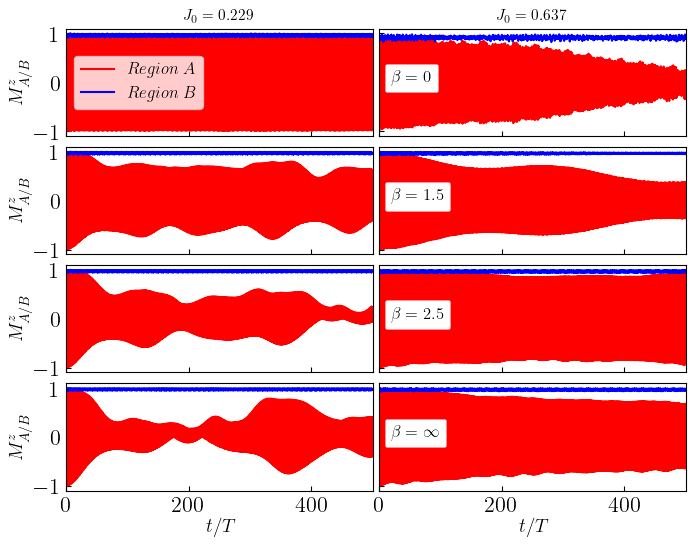

In [8]:
import matplotlib.pyplot as plt
import h5py
import numpy as np

plt.rcParams.update({"figure.figsize": (8., 6),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 16,"font.sans-serif": ["Helvetica"]})
w = 20
T = 2 * np.pi/w
jvalues = [0.072/T,0.2/T]

fig, axs = plt.subplots(4, 2, sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.02, hspace=0.1)

with open("mzfiles.txt", 'r') as fp:
    lines = fp.readlines()
    x = len(lines)
    for i in range(0,x):
        filename = lines[i][:-1]
        #print(filename)
        with h5py.File(filename, "r") as f:
            data = f['mz'][()]
            times = f['times'][()]
            N = f.attrs['N']
            Jvalue = f.attrs['Jvalue']
            beta = f.attrs['beta']
            region = f.attrs['region']
            
            if Jvalue == jvalues[0]:
                jh = 0
            else:
                jh = 1
                
            if beta == 0.0:
                ii = 0
                lbl = fr"$\beta={beta}$"
            if beta == 1.5:
                ii = 1
                lbl = fr"$\beta={beta}$"
            if beta == 2.5:
                ii = 2
                lbl = fr"$\beta={beta}$"
            if beta == float('inf'):
                ii = 3
                lbl = r"$\beta={\infty}$"
                
            if region == 'A':
                #print(ii,jh)
                axs[ii][jh].plot(times/T, data*2/N, color='red', label= fr"$Region$ ${region}$")
            if region == 'B':
                #print(ii,jh)
                axs[ii][jh].plot(times/T, data*2/N, color='blue', label= fr"$Region$ ${region}$")
                
            axs[0][0].legend(frameon = True, loc = 6, fontsize = 12)

            axs[ii][jh].set_xlim(0, 500)
            #axs[hh][jh].set_xscale('log')
            axs[ii][jh].tick_params(which='both', axis="x", direction="in")
            axs[ii][jh].tick_params(which='both', axis="y", direction="in")
            axs[0][jh].set_title(fr"$J_0 = {Jvalue:1.3f}$", fontsize= 11)
            

            axs[ii][0].set_ylabel(r"$M^z_{A/B}$",fontsize = 14, labelpad= 0.0)  
            
            if ii ==3:
                axs[ii][1].text(20, 0.0, lbl, fontsize=12, bbox=dict(facecolor='white', alpha=1.0, edgecolor='white'))
            else:
                axs[ii][1].text(20, 0.0, lbl, fontsize=12, bbox=dict(facecolor='white', alpha=1.0, edgecolor='white'))
            
            
axs[3][0].set_xlabel(r"$t/T$", fontsize = 14, labelpad= 0.5)
axs[3][1].set_xlabel(r"$t/T$", fontsize = 14, labelpad= 0.5)


plt.savefig('mz_betas.pdf', bbox_inches='tight', pad_inches=0.0, dpi = 600)
#plt.savefig('mz_betas.svg', bbox_inches='tight', pad_inches=0.0, dpi = 600)
plt.show()